In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import os
import matplotlib as mpl
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from experiments.configs.regression_consts import VALID_UQ_METHODS, VALID_ESTIMATORS, MODELS, DATASETS, SINGLE_CONFORMAL_METHODS
plt.rcParams['text.usetex'] = True
plt.rcParams.update({
    "text.usetex": True,              # Use TeX for text rendering
    "font.family": "serif",
    "hatch.color": "white"
})
%load_ext autoreload
%autoreload 2


In [2]:

def convert_results_to_df(results_dict):
   
    df = pd.DataFrame.from_dict(
        {(dataset, method, hyperparam): metrics
        for dataset, methods in results_dict.items()
        for (method, hyperparam), metrics in methods.items()},
        orient='index'
    )

    # Convert index into MultiIndex
    df.index = pd.MultiIndex.from_tuples(df.index, names=['Dataset', 'Method', 'Estimator'])

    # Reset index to move 'Dataset' to a normal column
    df = df.reset_index()

    # Pivot table to reshape
    df = df.pivot(index="Dataset", columns=["Method", "Estimator"])

    # Fix column ordering
    df.columns = df.columns.reorder_levels([1, 2, 0])  # Move metric to last level
    df = df.sort_index(axis=1)  # Sort for readability
    return df

# Load Results

In [3]:
train_size = 0.8
dataset_results = [pickle.load(open(f'../results/regression/aggregated_results/{dataset}_train_size_{train_size}_results.pkl', 'rb')) for dataset in DATASETS]
aggregated_results = pickle.load(open(f'../results/regression/aggregated_results/all_results_train_size_{train_size}.pkl', 'rb'))
df = convert_results_to_df(aggregated_results)
# Filter columns to only keep coverage_mean metric
df = df.loc[:, (slice(None), slice(None), ['mean_width_scaled_mean','mean_width_scaled_std','coverage_mean','coverage_std'])]

# Coverage 

In [4]:
df_coverage = df.loc[:, (slice(None), slice(None), ['coverage_mean','coverage_std'])]
# Create latex table for coverage 
df_coverage.to_latex(buf='coverage_table.tex', index=False)
# Create latex table for width 
df_width = df.loc[:, (slice(None), slice(None), ['mean_width_scaled_mean','mean_width_scaled_std'])]
df_width.to_latex(buf='width_table.tex', index=False)



# Plot Widths 

In [6]:
df_width = df.loc[:, (slice(None), slice(None), ['mean_width_scaled_mean'])]
df_width_split_conformal = df_width.loc[:, ('split_conformal', slice(None), slice(None))]
df_width_split_conformal.mean(axis=0) # XGBoost has lowest average width for split conformal 



Method           Estimator                           
split_conformal  AdaBoost      mean_width_scaled_mean    0.343580
                 ElasticNet    mean_width_scaled_mean    0.395557
                 ExtraTrees    mean_width_scaled_mean    0.316289
                 Lasso         mean_width_scaled_mean    0.395557
                 MLP           mean_width_scaled_mean    3.695655
                 OLS           mean_width_scaled_mean    0.352496
                 RandomForest  mean_width_scaled_mean    0.279146
                 Ridge         mean_width_scaled_mean    0.380113
                 XGBoost       mean_width_scaled_mean    0.235093
dtype: float64

In [7]:
df_width = df.loc[:, (slice(None), slice(None), ['mean_width_scaled_mean'])]
df_width_studentized_conformal = df_width.loc[:, ('studentized_conformal', slice(None), slice(None))]
df_width_studentized_conformal.mean(axis=0) # RandomForest has lowest average width for studentized conformal 
df_width = df_width.sort_values(by = ('pcs_oob','', 'mean_width_scaled_mean'), ascending=True)
df_width.sort_values(by = ('pcs_oob','', 'mean_width_scaled_mean'), ascending=True)

Method                          majority_vote                pcs_oob  \
Estimator                                                              
                       mean_width_scaled_mean mean_width_scaled_mean   
Dataset                                                                
data_naval_propulsion                0.010334               0.001436   
data_energy_efficiency               0.348779               0.030234   
data_computer                        0.260427               0.066066   
data_miami_housing                   0.223116               0.075536   
data_diamond                         0.252196               0.093122   
data_insurance                       0.465203               0.127110   
data_elevator                        0.320834               0.127336   
data_airfoil                         0.561860               0.134421   
data_powerplant                      0.237661               0.138934   
data_concrete                        0.528126               0.172136   
data_debutanizer                     0.523032               0.187220   
data_superconductor                  0.489507               0.193270   
data_parkinsons                      0.828228               0.201017   
data_ca_housing                      0.638120               0.271490   
data_kin8nm                          0.538717               0.282523   
data_qsar                            0.478358               0.314719   
data_protein_structure               0.927959               0.570666   

Method                                 pcs_uq        split_conformal  \
Estimator                                                   AdaBoost   
                       mean_width_scaled_mean mean_width_scaled_mean   
Dataset                                                                
data_naval_propulsion                0.001432               0.030527   
data_energy_efficiency               0.034545               0.205760   
data_computer                        0.066860               0.131997   
data_miami_housing                   0.079651               0.211240   
data_diamond                         0.094462               0.241065   
data_insurance                       0.178572               0.243446   
data_elevator                        0.133133               0.252702   
data_airfoil                         0.158839               0.372666   
data_powerplant                      0.147187               0.217862   
data_concrete                        0.208779               0.327362   
data_debutanizer                     0.206164               0.385583   
data_superconductor                  0.221062               0.407786   
data_parkinsons                      0.206299               0.540254   
data_ca_housing                      0.275363               0.549770   
data_kin8nm                          0.286312               0.485213   
data_qsar                            0.310606               0.483361   
data_protein_structure               0.596237               0.754265   

Method                                                                \
Estimator                          ElasticNet             ExtraTrees   
                       mean_width_scaled_mean mean_width_scaled_mean   
Dataset                                                                
data_naval_propulsion                0.072640               0.003734   
data_energy_efficiency               0.392219               0.148969   
data_computer                        0.351930               0.097151   
data_miami_housing                   0.194030               0.107122   
data_diamond                         0.164581               0.133905   
data_insurance                       0.340645               0.370902   
data_elevator                        0.249236               0.188283   
data_airfoil                         0.608280               0.476359   
data_powerplant                      0.196625               0.324660   
data_concrete                        0

In [28]:
df_best = df.loc[:, (['pcs_oob','split_conformal','studentized_conformal','majority_vote'], ['','XGBoost','RandomForest'], ['mean_width_scaled_mean'])]
df_best = df_best.drop(('studentized_conformal', 'XGBoost', 'mean_width_scaled_mean'), axis=1)
df_best = df_best.drop(('split_conformal', 'RandomForest', 'mean_width_scaled_mean'), axis=1)
# Compute percentage improvement of pcs_oob for each other method
# Calculate percentage improvement of pcs_oob over each other method
# Create a DataFrame to store improvement percentages
improvements_data = []
pcs_oob_values = df_best[('pcs_oob', '', 'mean_width_scaled_mean')]

# Calculate percentage improvement for each dataset
for dataset in df_best.index:
    pcs_oob_value = df_best.loc[dataset, ('pcs_oob', '', 'mean_width_scaled_mean')]
    
    for col in df_best.columns:
        if col[0] != 'pcs_oob':
            method_name = f"{col[0]}_{col[1]}" if col[1] else col[0]
            other_value = df_best.loc[dataset, col]
            improvement = ((other_value - pcs_oob_value) / other_value) * 100
            improvements_data.append({
                'dataset': dataset,
                'method': method_name,
                'improvement_percent': improvement
            })

# Create DataFrame from the collected data
improvements_df = pd.DataFrame(improvements_data)
improvements_df = improvements_df.set_index('dataset')
# Display the improvements DataFrame
improvements_df.pivot_table(index='dataset', columns='method', values='improvement_percent')

# Create a box plot of improvements
plt.figure(figsize=(12, 8))

# Pivot the improvements dataframe for easier plotting
improvements_pivot = improvements_df.pivot_table(index='dataset', columns='method', values='improvement_percent')

# Prepare data for boxplot
boxplot_data = []
labels = []

for col in improvements_pivot.columns:
    boxplot_data.append(improvements_pivot[col].values)
    labels.append(col)
improvements_pivot.head()
boxplot_data_reordered = []
boxplot_data_reordered.append(boxplot_data[1])
boxplot_data_reordered.append(boxplot_data[2])
boxplot_data_reordered.append(boxplot_data[0])
boxplot_data = boxplot_data_reordered

<Figure size 1200x800 with 0 Axes>

In [27]:
boxplot_data.shape

AttributeError: 'list' object has no attribute 'shape'

<>:105: SyntaxWarning: invalid escape sequence '\%'
<>:105: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_2406919/3454261625.py:105: SyntaxWarning: invalid escape sequence '\%'
  inset_ax.set_title('\% Reduction in Width of PCS OOB', fontsize=14)


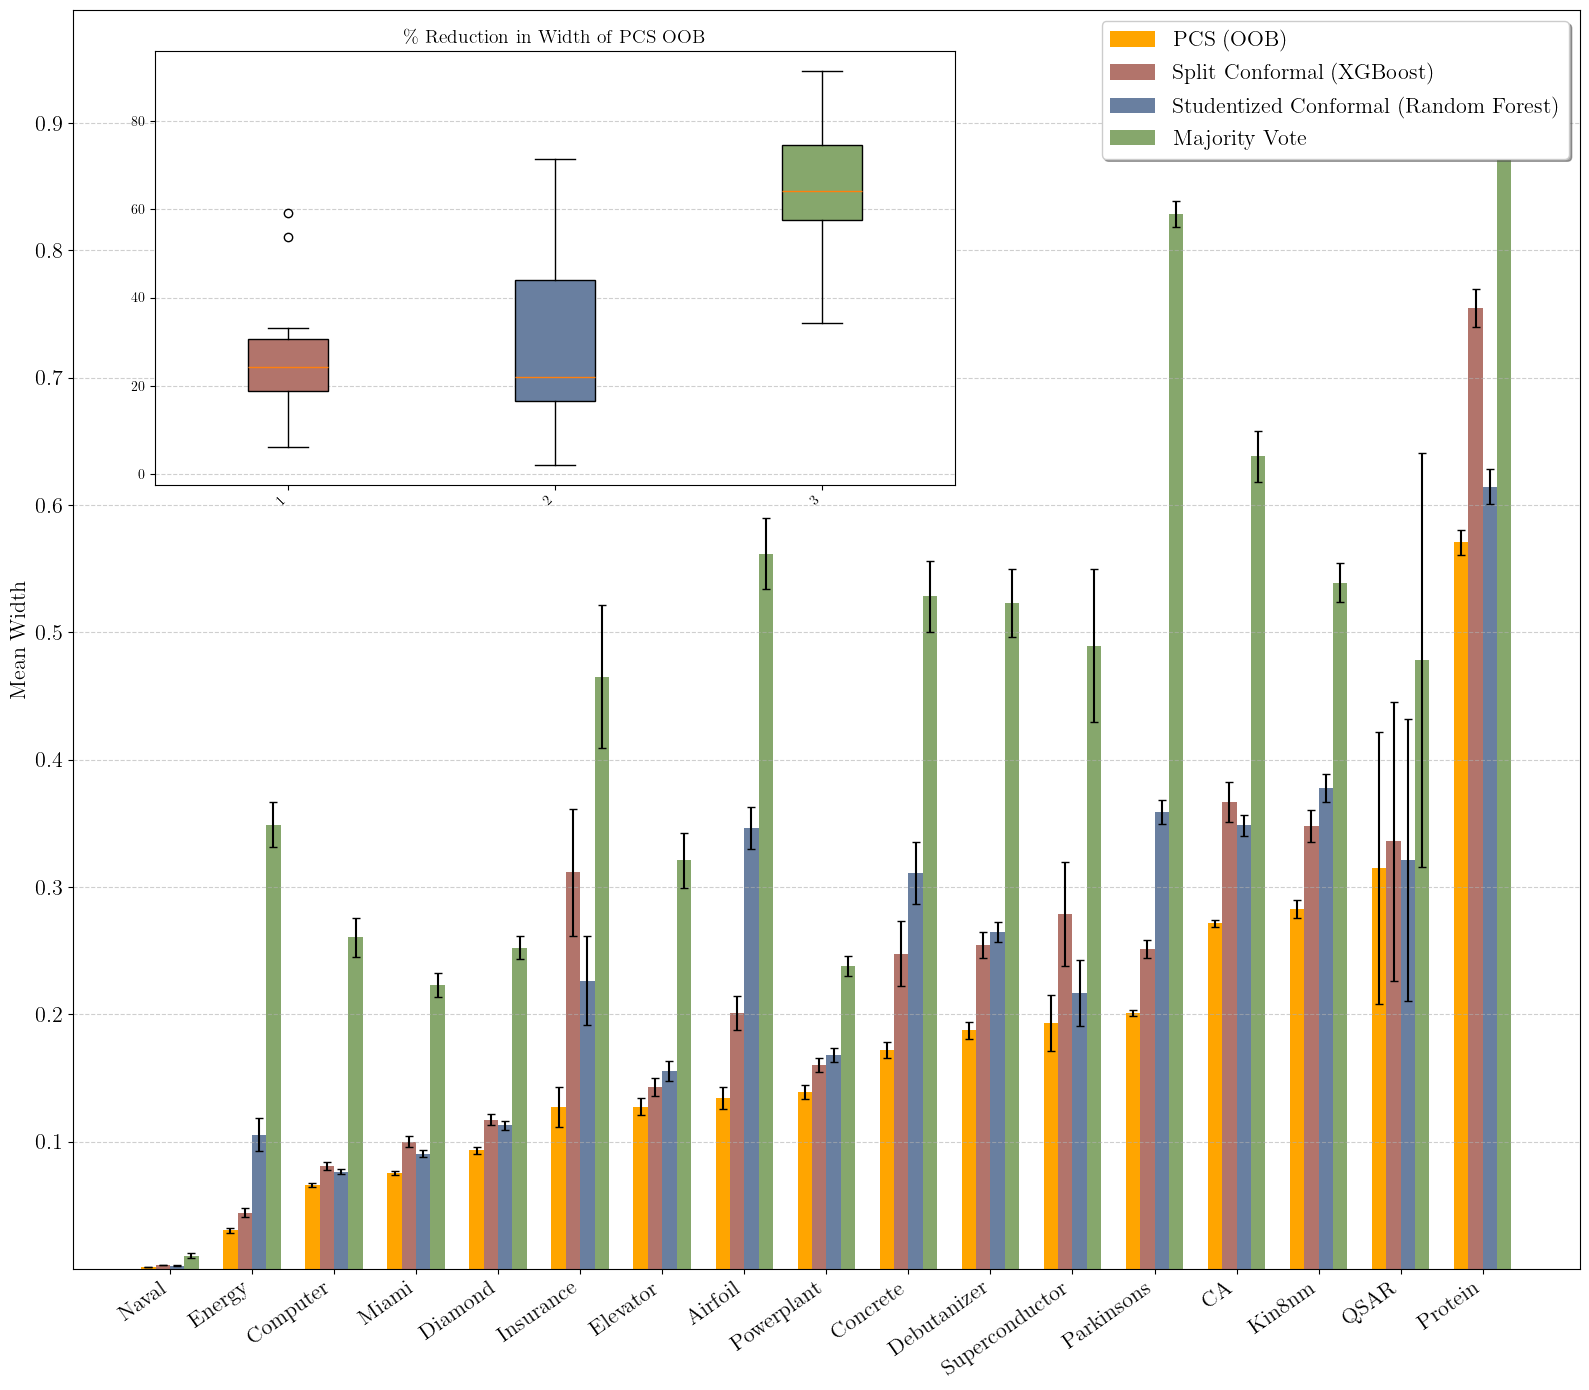

In [ ]:
# Create a bar plot of the mean_width_scaled_mean for each method and std deviation of the mean_width_scaled_mean. Only plot for pcs_uq, pcs_oob, split_conformal_xgb, studentized_conformal_rf, majority_vote
# Select methods to plot
methods_to_plot = [
    #('pcs_uq', ''),
    ('pcs_oob', ''),
    ('split_conformal', 'XGBoost'),
    ('studentized_conformal', 'RandomForest'),
    ('majority_vote', '')
]
legend_dict = {'majority_vote': 'Majority Vote', 'split_conformal_XGBoost': 'Split Conformal (XGBoost)', 'studentized_conformal_RandomForest': 'Studentized Conformal (Random Forest)', 'pcs_uq': 'PCS', 'pcs_oob': 'PCS (OOB)'}
data_dict = {'data_airfoil': 'Airfoil', 'data_ca_housing': 'CA', 'data_concrete': 'Concrete', 'data_parkinsons': 'Parkinsons',
             'data_energy_efficiency': 'Energy', "data_computer": "Computer", "data_kin8nm": "Kin8nm",
             "data_diamond": "Diamond", "data_elevator": "Elevator", "data_protein_structure": "Protein",
             "data_naval_propulsion": "Naval", "data_powerplant": "Powerplant", "data_qsar": "QSAR", 'data_superconductor': 'Superconductor',
             "data_miami_housing": "Miami", "data_debutanizer": "Debutanizer", "data_insurance": "Insurance"}
colors = {'PCS (OOB)': 'orange', 'Split Conformal (XGBoost)': '#B2746B', 'Studentized Conformal (Random Forest)': '#697fa0', 'Majority Vote': '#86a76c', 'PCS': 'gray'}
              
              
plt.figure(figsize=(16, 14), dpi=100)
# Add text next to each bar displaying % improve of PCS OOB over next best conformal method



# Set up transparency values
alpha_values = {}
for method, _ in methods_to_plot:
    if method == 'pcs_uq':
        alpha_values[method] = 0.6
    elif method == 'pcs_oob':
        alpha_values[method] = 1.0
    else:
        alpha_values[method] = 1.0 # Lower opacity for non-PCS methods

# Get data for plotting
plot_data = []
plot_errors = []
labels = []
df = df.sort_values(by = ('pcs_oob','', 'mean_width_scaled_mean'), ascending=True)
for method, estimator in methods_to_plot:
    method_name = f"{method}_{estimator}" if estimator else method
    means = df.loc[:, (method, estimator, 'mean_width_scaled_mean')].values
    stds = df.loc[:, (method, estimator, 'mean_width_scaled_std')].values
    plot_data.append(means)
    plot_errors.append(stds)
    labels.append(legend_dict[method_name])

# Convert to numpy arrays
plot_data = np.array(plot_data)
plot_errors = np.array(plot_errors)

# Set up bar positions
n_methods = len(methods_to_plot)
n_datasets = len(df.index)
width = 0.35  # Width of bars
x = np.arange(n_datasets)

# Create color palette
#colors = plt.cm.Set3(np.linspace(0, 1, n_methods))
# Increase spacing between x-ticks by adjusting figure size and/or x positions

# Increase spacing between x positions
x = np.arange(n_datasets) * 2.0 # Multiply by 1.5 to increase gaps between bars

# Plot bars
for i in range(n_methods):
    plt.bar(x + i*width - (n_methods-1)*width/2, 
            plot_data[i], 
            width,
            label=labels[i],
            yerr=plot_errors[i],
            capsize=3,
            alpha=alpha_values[methods_to_plot[i][0]],
            color=colors[labels[i]])


# Customize plot
#plt.xlabel('Dataset', fontsize=16)
plt.ylabel('Mean Width', fontsize=16)
#plt.yscale('log')
#plt.title('Prediction Interval Widths by Method and Dataset', fontsize=14, fontweight='bold', pad=20)

# Set x-axis ticks and labels
plt.xticks(x, [data_dict[dataset] for dataset in df.index], rotation=35, ha='right', fontsize=16)
plt.yticks(ticks = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], fontsize=16)

# Add some style elements
#plt.gca().set_facecolor('#f8f9fa')
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.legend(frameon=True, fancybox=True, shadow=True, loc='upper right', fontsize=16)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
# Add a dummy inset plot
# Create an inset axes
inset_ax = plt.axes([0.1, 0.65, 0.5, 0.31], facecolor='white')  # [left, bottom, width, height] in figure coordinates
# Create a simple box plot with dummy data
#labels=['Split Conformal (XGBoost)', 'Studentized Conformal (Random Forest)', 'Majority Vote']
inset = inset_ax.boxplot(boxplot_data, patch_artist=True)
# Add labels and title
colors = ['#B2746B', '#697fa0', '#86a76c']
for patch, color in zip(inset['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(1.0)
# Customize inset plot
inset_ax.set_title('\% Reduction in Width of PCS OOB', fontsize=14)
inset_ax.set_yticklabels(['0\%','20\%','40\%','60\%','80\%'])
inset_ax.grid(True, axis='y', linestyle='--', alpha=0.6)



# Rotate the x-tick labels in the inset plot
plt.setp(inset_ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)


# Add a box around the inset
inset_ax.spines['top'].set_visible(True)
inset_ax.spines['right'].set_visible(True)
inset_ax.spines['bottom'].set_visible(True)
inset_ax.spines['left'].set_visible(True)


# for i in range(n_datasets):
#     pcs_oob_value = plot_data[0, i]  # PCS OOB value
#     next_best_value = min(plot_data[1:4, i])  # Next best conformal method value
#     improvement = ((next_best_value - pcs_oob_value) / next_best_value) * 100  # Calculate % improvement
#     widths = plot_data[:, i]
#     y_loc = max(widths) + 0.02
#     plt.text(x[i] + width , y_loc, f"+{improvement:.1f}\%", alpha=0.8, 
#              ha='center', va='bottom', fontsize=11, fontweight='bold',
#              bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.savefig('figures/regression_widths_inset.pdf', dpi=2000, bbox_inches='tight')
#- (n_methods-1)*width/2